In [42]:
import copy
import random

In [74]:
import pandas
import pickle

In [4]:
import rospy
rospy.init_node('notebook_explore_controller_goal_states')

In [8]:
import moveit_commander

In [57]:
def set_scaling_factors(arm, factor):
    arm.set_max_velocity_scaling_factor(factor)
    arm.set_max_acceleration_scaling_factor(factor)

In [142]:
arm= moveit_commander.MoveGroupCommander('right_arm')
arm.set_goal_tolerance(0.0)

In [143]:
set_scaling_factors(arm, 0.5)

In [144]:
import moveit_msgs.srv as srvs
list_states = rospy.ServiceProxy('list_robot_states', srvs.ListRobotStatesInWarehouse)
get_state = rospy.ServiceProxy('get_robot_state', srvs.GetRobotStateFromWarehouse)

In [145]:
state_names = list_states().states
print(state_names)

['tams_pr2_state_0000', 'tams_pr2_state_0001', 'tams_pr2_state_0002', 'tams_pr2_state_0003', 'tams_pr2_state_0004', 'tams_pr2_state_0005', 'tams_pr2_state_0006', 'tams_pr2_state_0007', 'tams_pr2_state_0008']


In [146]:
def filter_joints(state, joints):
    filtered = copy.deepcopy(state)
    filtered.name = []
    filtered.position = []
    filtered.velocity = []
    filtered.effort = []
    for i in range(len(state.name)):
        if state.name[i] in joints:
            filtered.name.append(state.name[i])
            filtered.position.append(state.position[i])
            if i < len(filtered.velocity):
                filtered.velocity.append(state.velocity[i])
            if i < len(filtered.effort):
                filtered.effort.append(state.effort[i])
    return filtered

In [147]:
states= {}
for s in state_names:
    states[s] = filter_joints(
        arm.enforce_bounds(
            get_state(srvs.GetRobotStateFromWarehouseRequest(name= s)).state
        ).joint_state,
        arm.get_joints())

In [148]:
state = next(iter(states.values()))
print(state)

header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: "base_footprint"
name: 
  - r_shoulder_pan_joint
  - r_shoulder_lift_joint
  - r_upper_arm_roll_joint
  - r_elbow_flex_joint
  - r_forearm_roll_joint
position: [-1.2305940696156474, 0.8552668389009519, -0.20594958821596565, -1.3745676654502255, -0.05169378117540703]
velocity: []
effort: []


In [149]:
recordings = []

In [150]:
set_scaling_factors(arm, 1.0)

In [151]:
for x in range(20):
    states_shuffled = random.sample(list(states.items()), len(states))
    print("\nepisode " + str(x) + " ", end='')
    for s in states_shuffled:
        print(".",end='')
        arm.set_joint_value_target(filter_joints(s[1], arm.get_joints()))
        arm.go()
        recordings.append(
            (s[0],
             {'rh_palm' : arm.get_current_pose("rh_palm"),
              'rh_forearm' : arm.get_current_pose("rh_forearm")},
             arm.get_current_joint_values())
        )


episode 0 .........
episode 1 .........
episode 2 .........
episode 3 .........
episode 4 .........
episode 5 .........
episode 6 .........
episode 7 .........
episode 8 .........
episode 9 .........
episode 10 .........
episode 11 .........
episode 12 .........
episode 13 .........
episode 14 .........
episode 15 .........
episode 16 .........
episode 17 .........
episode 18 .........
episode 19 .........

In [179]:
import matplotlib.pyplot as plt
import numpy as np
import math
np.tau = math.tau

In [153]:
pickle.dump(recordings,
            open("controller_goal_measurements_20episodes_full_speed_0_tolerance.pkl", 'wb')
           )

In [154]:
X=[state_names.index(s[0]) for s in recordings]

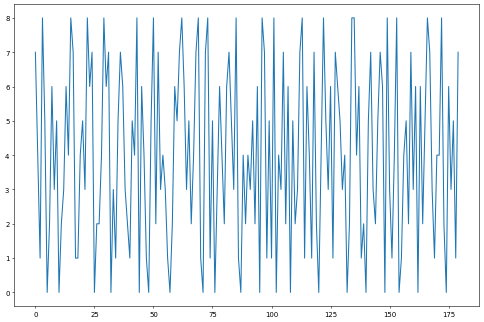

In [155]:
fig = plt.figure(figsize= (12,8), dpi= 50)
plt.plot(X)

In [156]:
i = 1
ri = [rec for rec in recordings if rec[0] == state_names[i]]

In [157]:
def plot_resized_scatter(ax, x,y):
    ax.scatter(x, y)
    ax.plot(x, y, color= 'none')
    ax.relim()
    ax.autoscale_view()

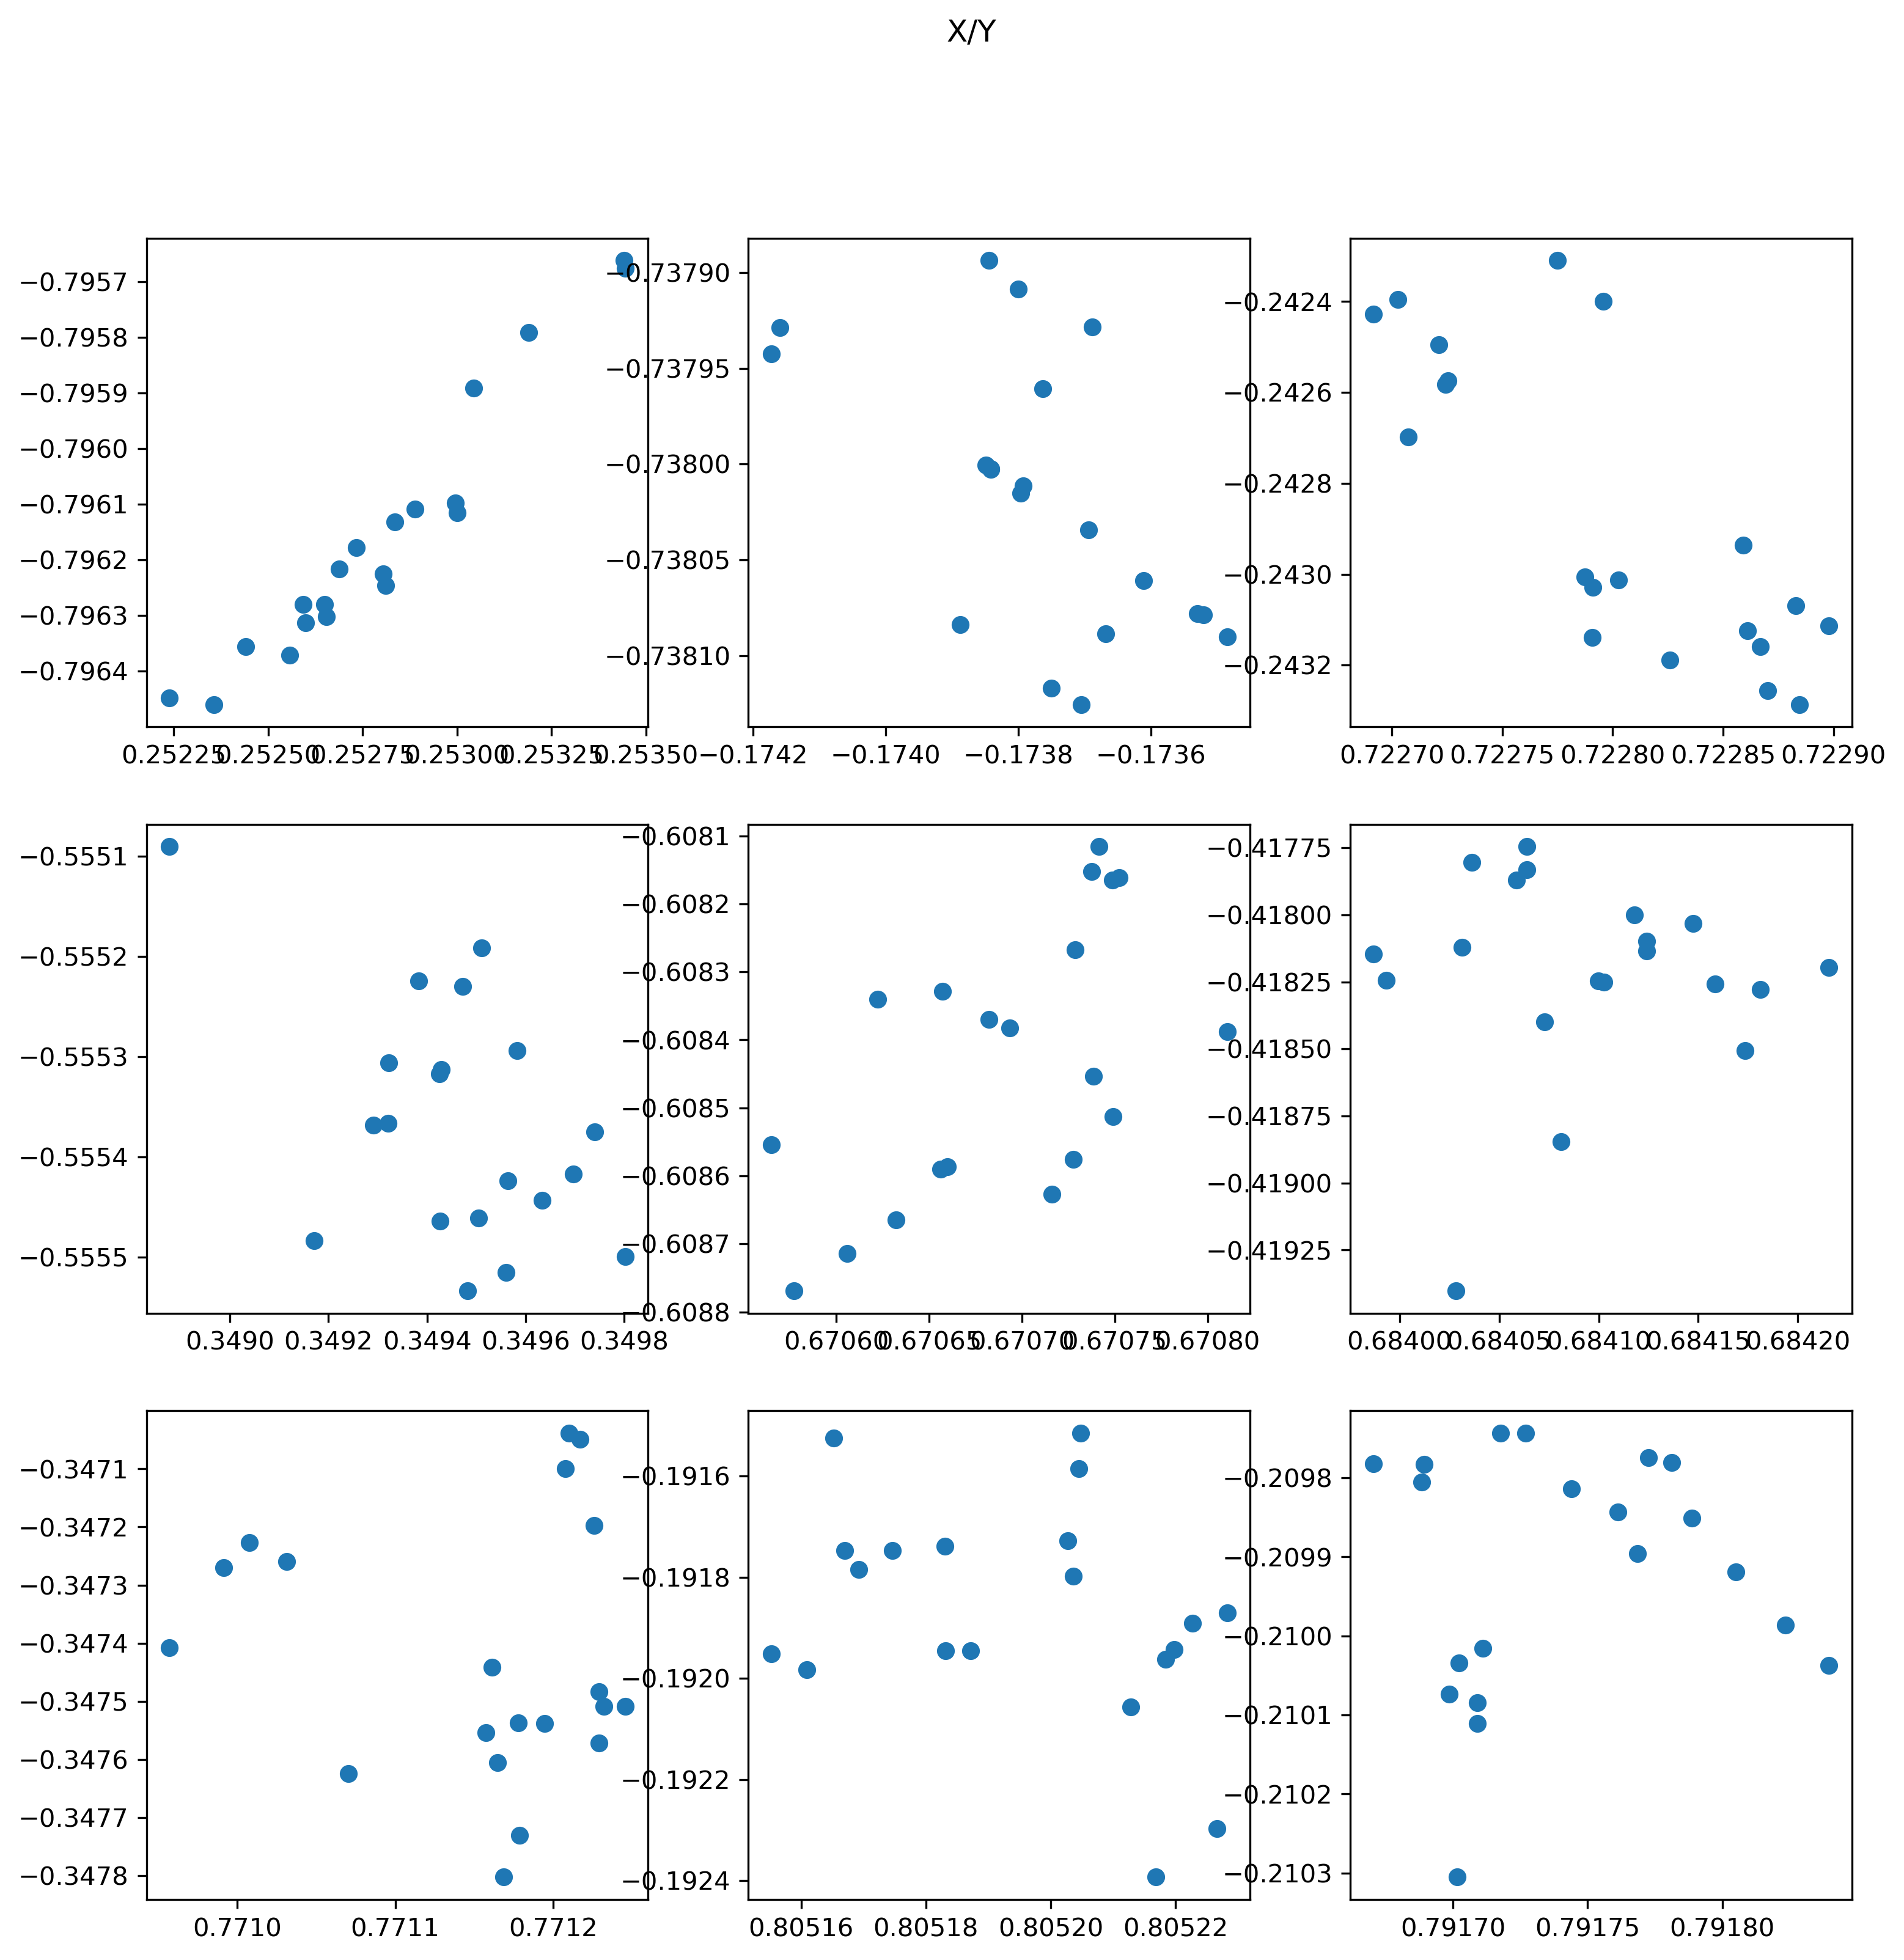

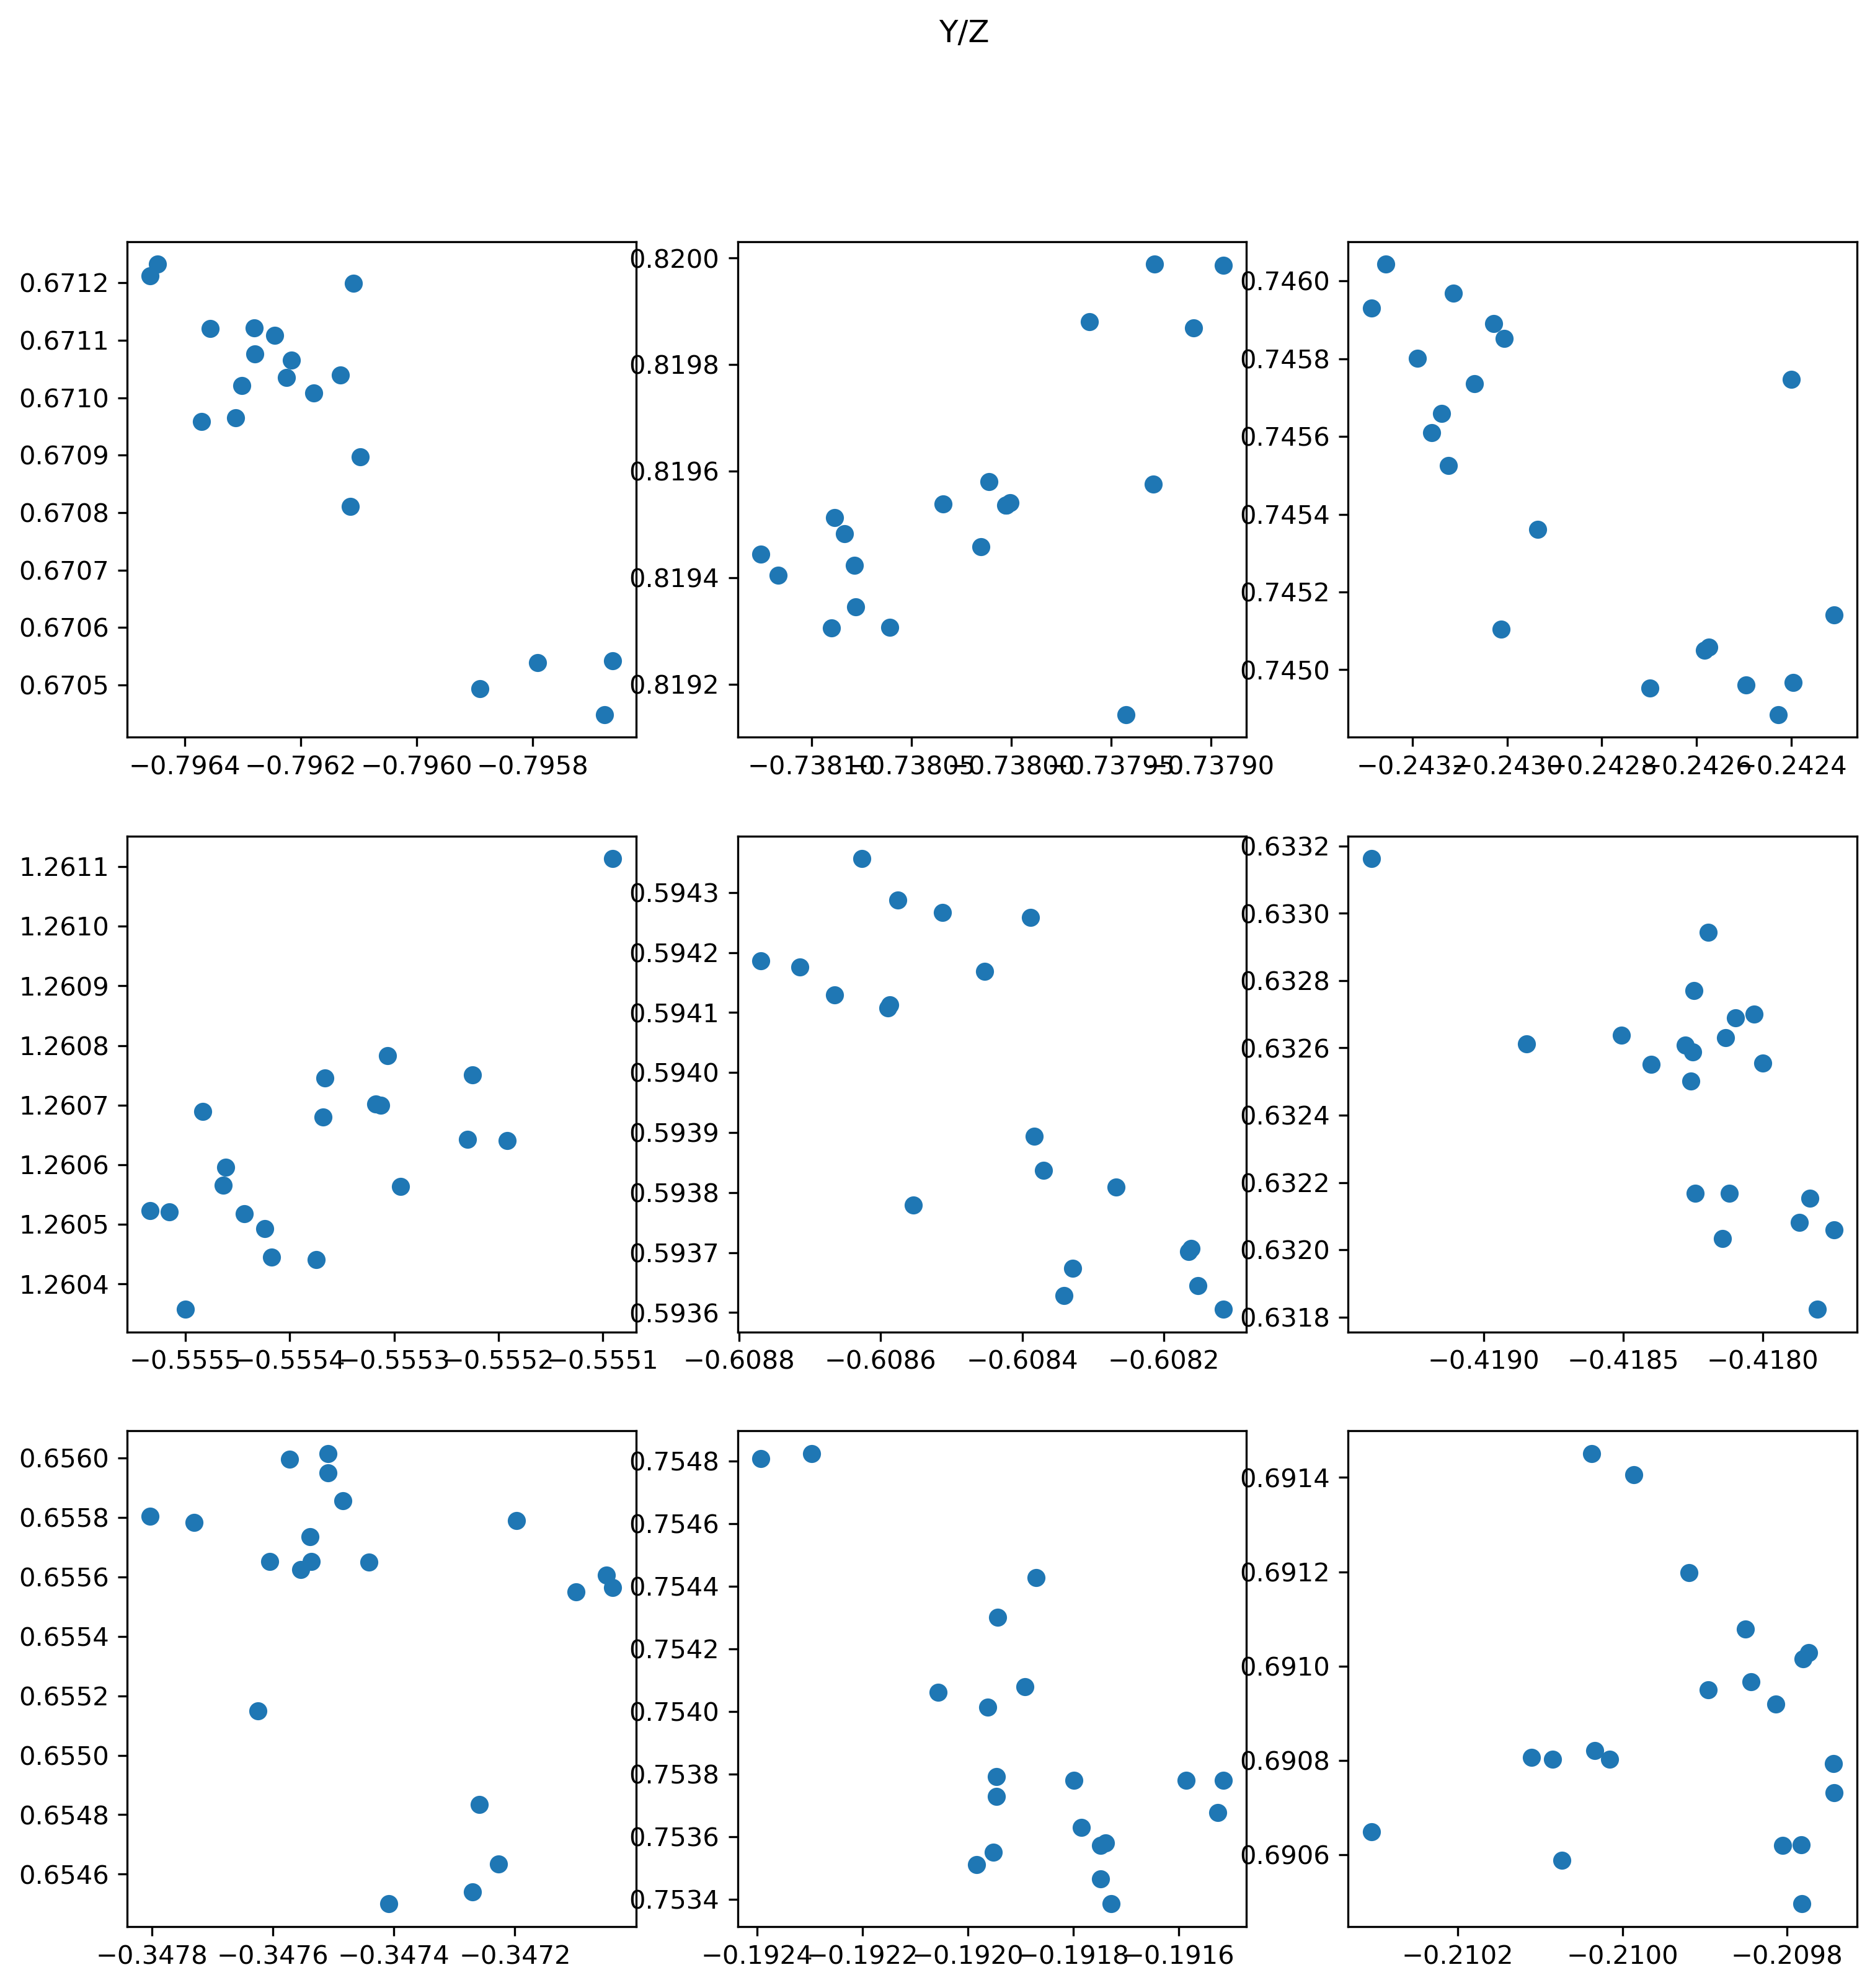

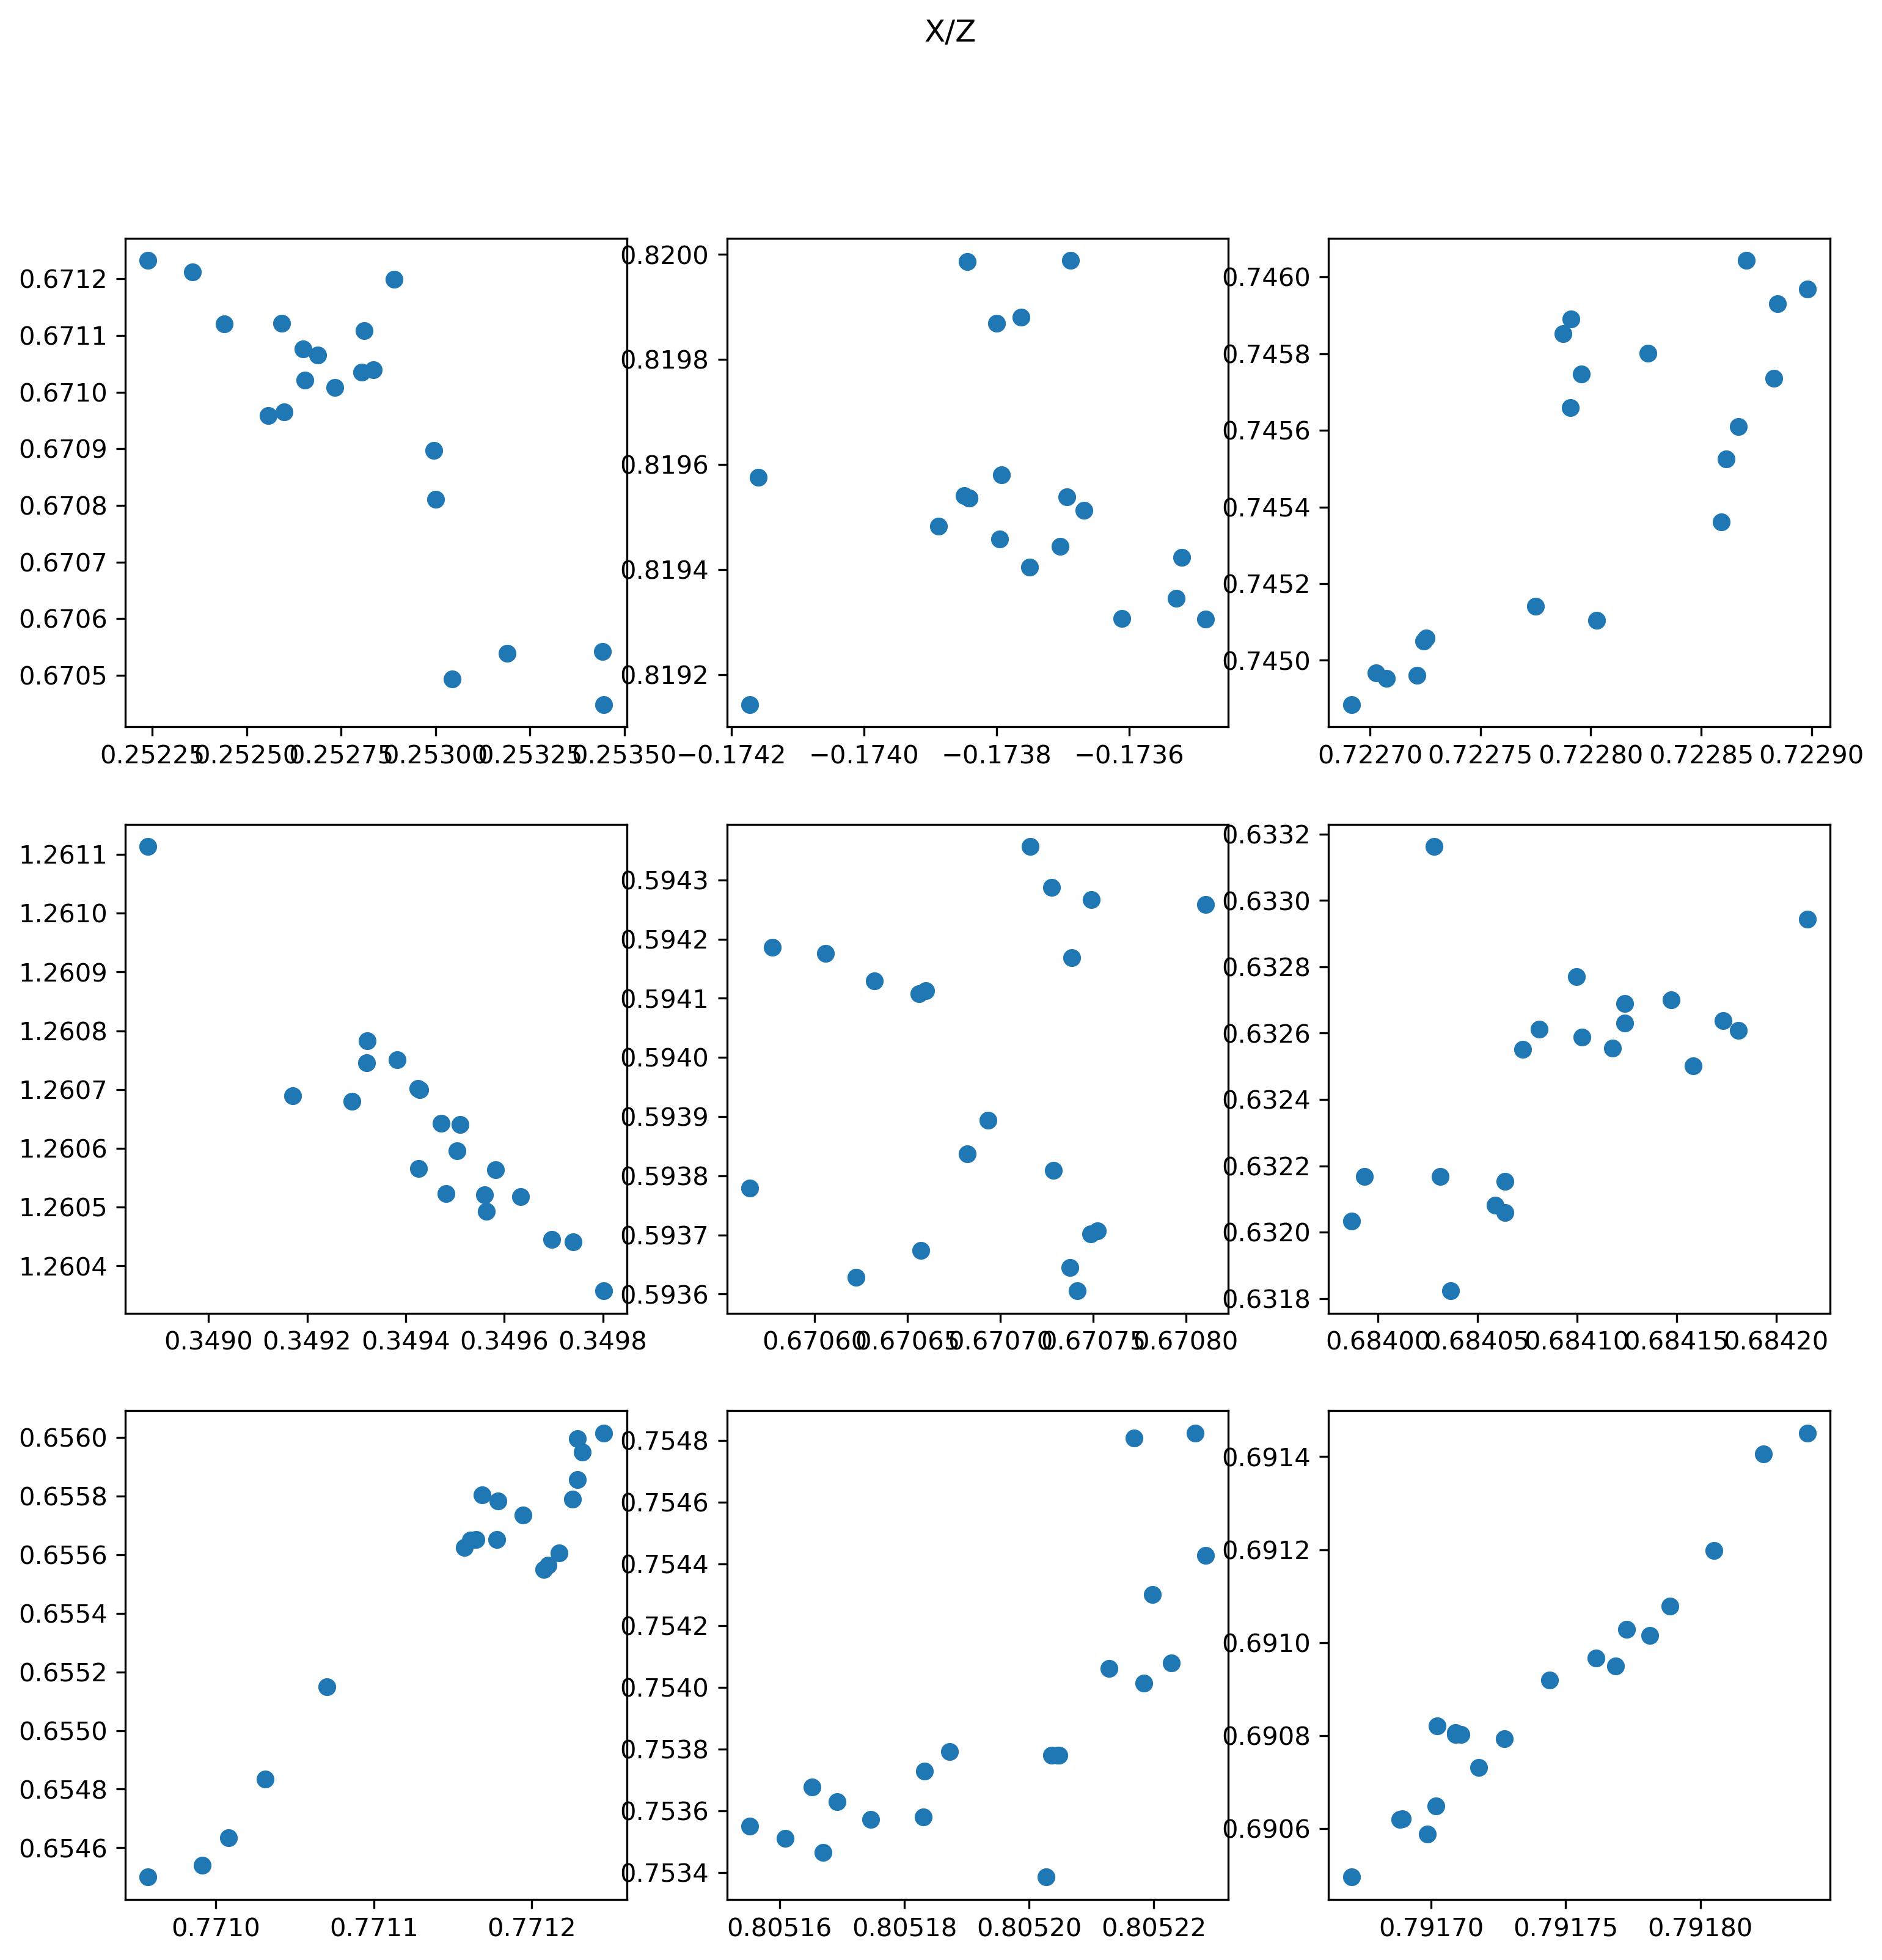

In [164]:
figXY = plt.figure(figsize= (12,12), dpi= 300)
figXY.suptitle('X/Y')

figYZ = plt.figure(figsize= (12,12), dpi= 300)
figYZ.suptitle('Y/Z')

figXZ = plt.figure(figsize= (12,12), dpi= 300)
figXZ.suptitle('X/Z')

X_per_target= {}
X_forearm_per_target= {}
for i in range(9):
    ri = [rec for rec in recordings if rec[0] == state_names[i]]
    X_palm= np.array([(r[1]['rh_palm'].pose.position.x,
         r[1]['rh_palm'].pose.position.y,
         r[1]['rh_palm'].pose.position.z)
         for r in ri])
    X= X_palm
    X_forearm= np.array([(r[1]['rh_forearm'].pose.position.x,
         r[1]['rh_forearm'].pose.position.y,
         r[1]['rh_forearm'].pose.position.z)
         for r in ri])
    X_per_target[state_names[i]]= X
    X_forearm_per_target[state_names[i]]= X_forearm
    plot_resized_scatter(figXY.add_subplot(3,3,i+1), X[:,0], X[:,1])
    plot_resized_scatter(figYZ.add_subplot(3,3,i+1), X[:,1], X[:,2])
    plot_resized_scatter(figXZ.add_subplot(3,3,i+1), X[:,0], X[:,2])
figXY.savefig('controller_goal_measurements_cartesian_palm_xy.png')
figYZ.savefig('controller_goal_measurements_cartesian_palm_yz.png')
figXZ.savefig('controller_goal_measurements_cartesian_palm_xz.png')

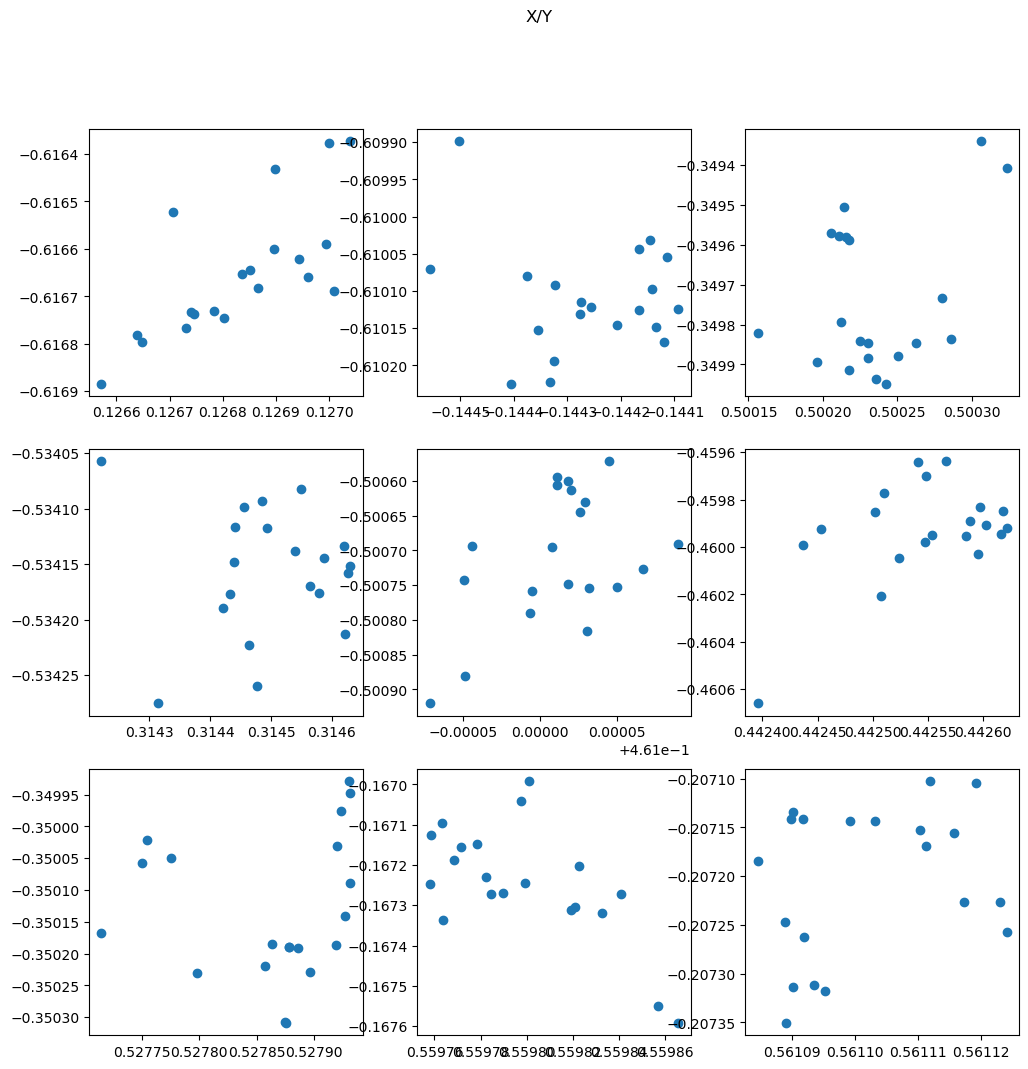

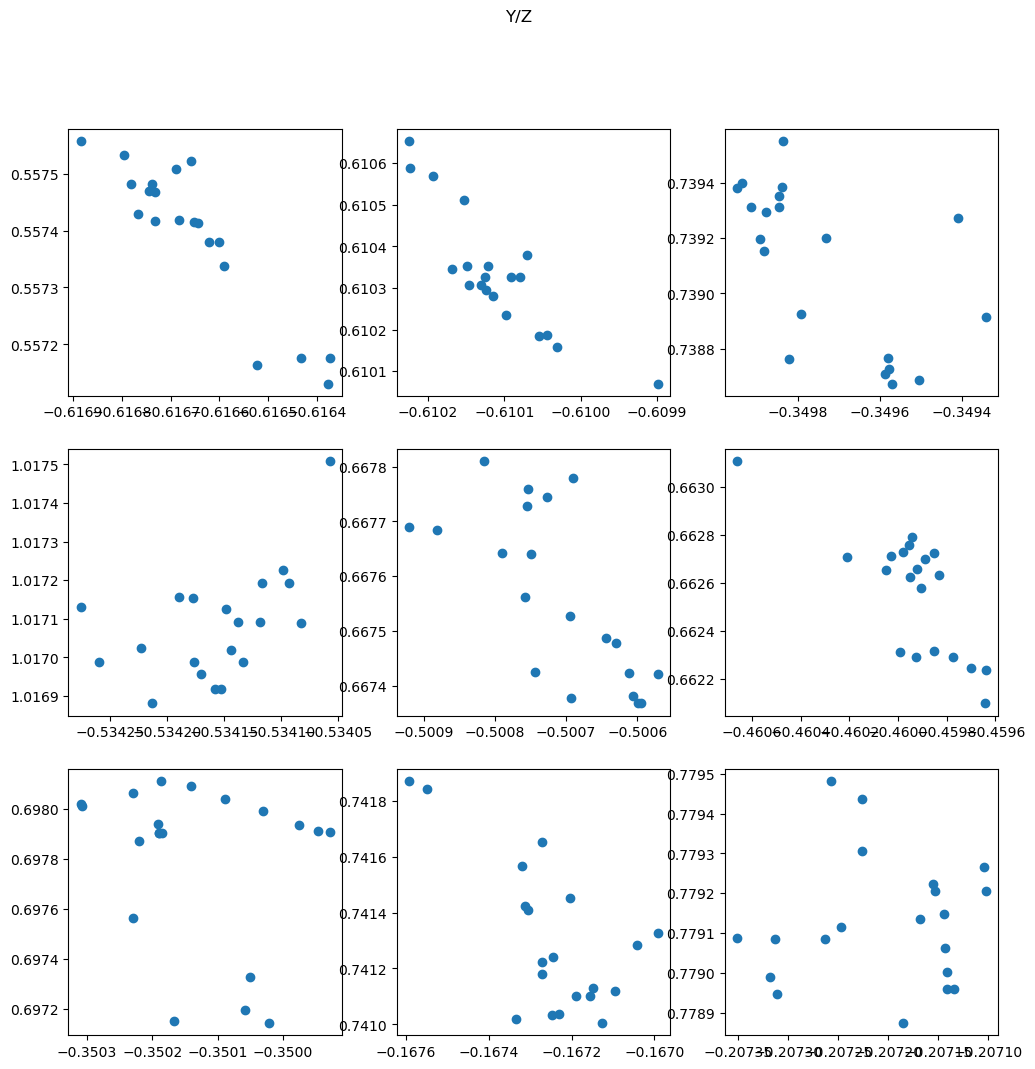

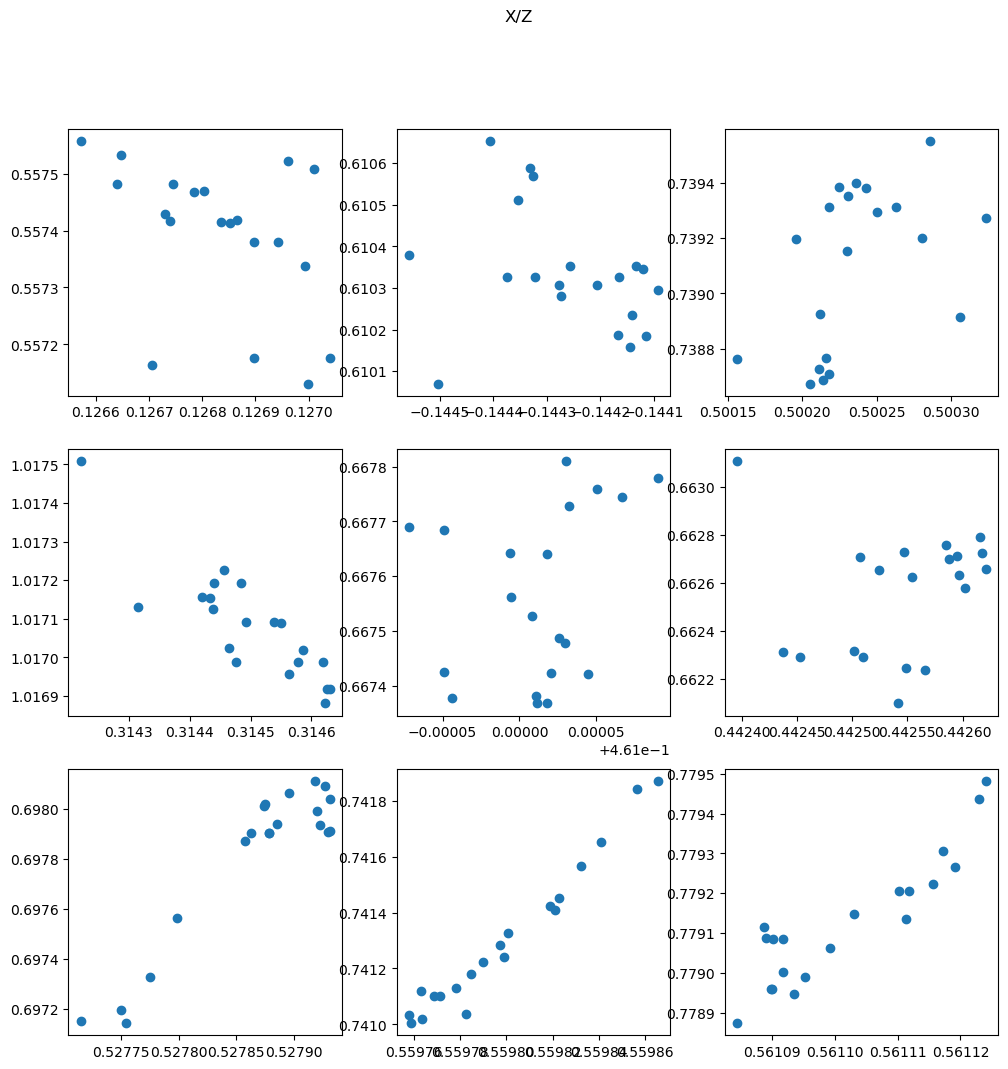

In [165]:
figXY = plt.figure(figsize= (12,12), dpi= 100)
figXY.suptitle('X/Y')

figYZ = plt.figure(figsize= (12,12), dpi= 100)
figYZ.suptitle('Y/Z')

figXZ = plt.figure(figsize= (12,12), dpi= 100)
figXZ.suptitle('X/Z')

for i in range(9):
    ri = [rec for rec in recordings if rec[0] == state_names[i]]
    X_palm= np.array([(r[1]['rh_palm'].pose.position.x,
         r[1]['rh_palm'].pose.position.y,
         r[1]['rh_palm'].pose.position.z)
         for r in ri])
    X_forearm= np.array([(r[1]['rh_forearm'].pose.position.x,
         r[1]['rh_forearm'].pose.position.y,
         r[1]['rh_forearm'].pose.position.z)
         for r in ri])
    X= X_forearm
    X_per_target[state_names[i]]= X
    X_forearm_per_target[state_names[i]]= X_forearm
    plot_resized_scatter(figXY.add_subplot(3,3,i+1), X[:,0], X[:,1])
    plot_resized_scatter(figYZ.add_subplot(3,3,i+1), X[:,1], X[:,2])
    plot_resized_scatter(figXZ.add_subplot(3,3,i+1), X[:,0], X[:,2])
figXY.savefig('controller_goal_measurements_cartesian_forearm_xy.png')
figYZ.savefig('controller_goal_measurements_cartesian_forearm_yz.png')
figXZ.savefig('controller_goal_measurements_cartesian_forearm_xz.png')

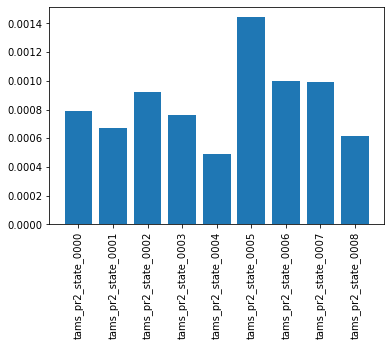

In [170]:
X= X_per_target[state_names[0]]
import scipy.spatial.distance

plt.xticks(rotation=90)
plt.bar(state_names, [scipy.spatial.distance.pdist(X_per_target[name]).max() for name in state_names])
plt.savefig('controller_goal_measurements_maximum_cartesian_error_palm.png', dpi=500)

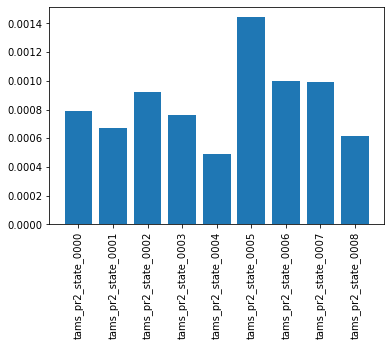

In [230]:
plt.xticks(rotation=90)
plt.bar(state_names, [scipy.spatial.distance.pdist(X_forearm_per_target[name]).max() for name in state_names])
plt.savefig('controller_goal_measurements_maximum_cartesian_error_forearm.png', dpi=500)

In [ ]:
prec= []
for i in range(9):
    ri = [rec for rec in recordings if rec[0] == state_names[i]]

In [184]:
X[:,4]= X[:,4]-(X[:,4]//np.tau)*np.tau

array([1.38103808, 1.38103808, 1.38102981, 1.38102981, 1.38102981,
       1.38097197, 1.38080669, 1.38075711, 1.38076537, 1.3810546 ,
       1.3810546 , 1.38104634, 1.38076537, 1.3810546 , 1.38093891,
       1.38099676, 1.3810546 , 1.3810546 , 1.38099676, 1.38104634])

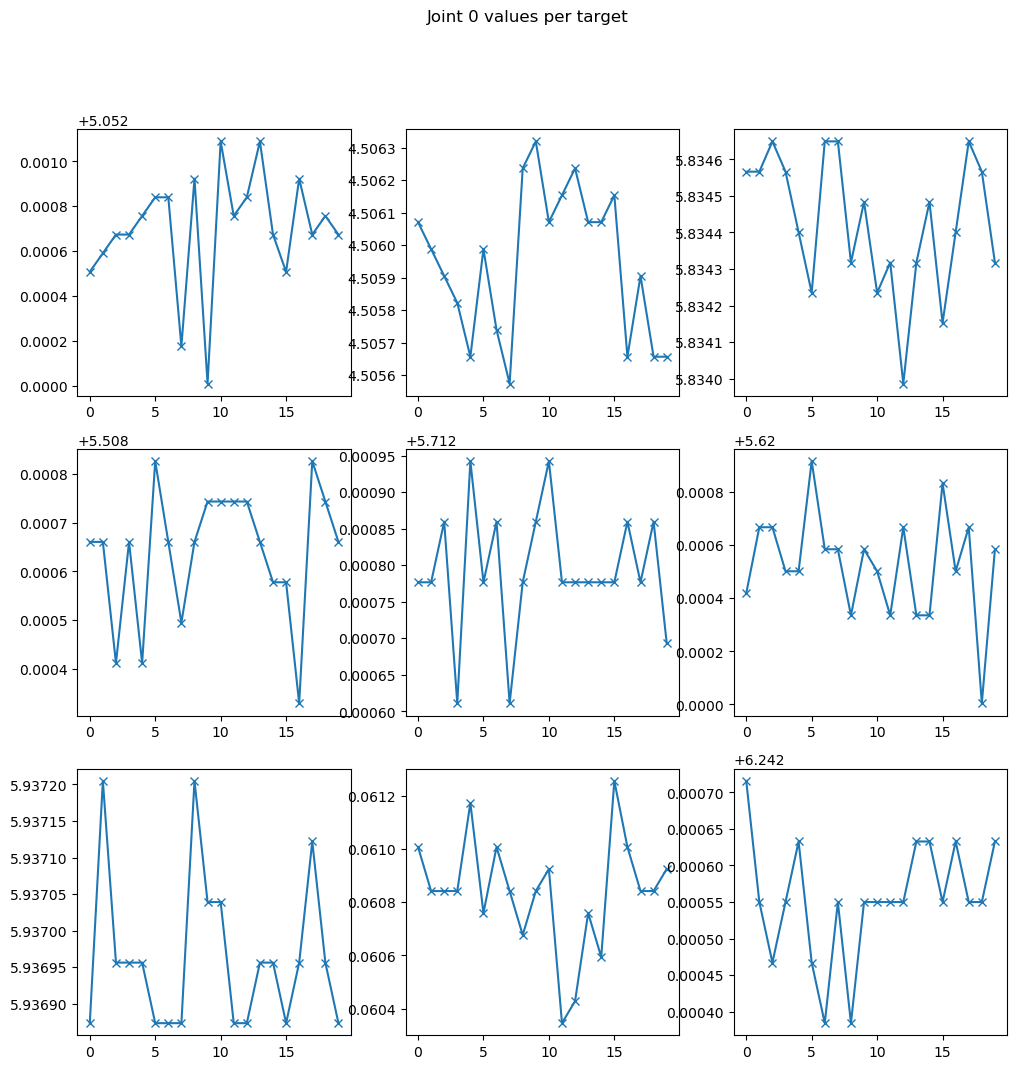

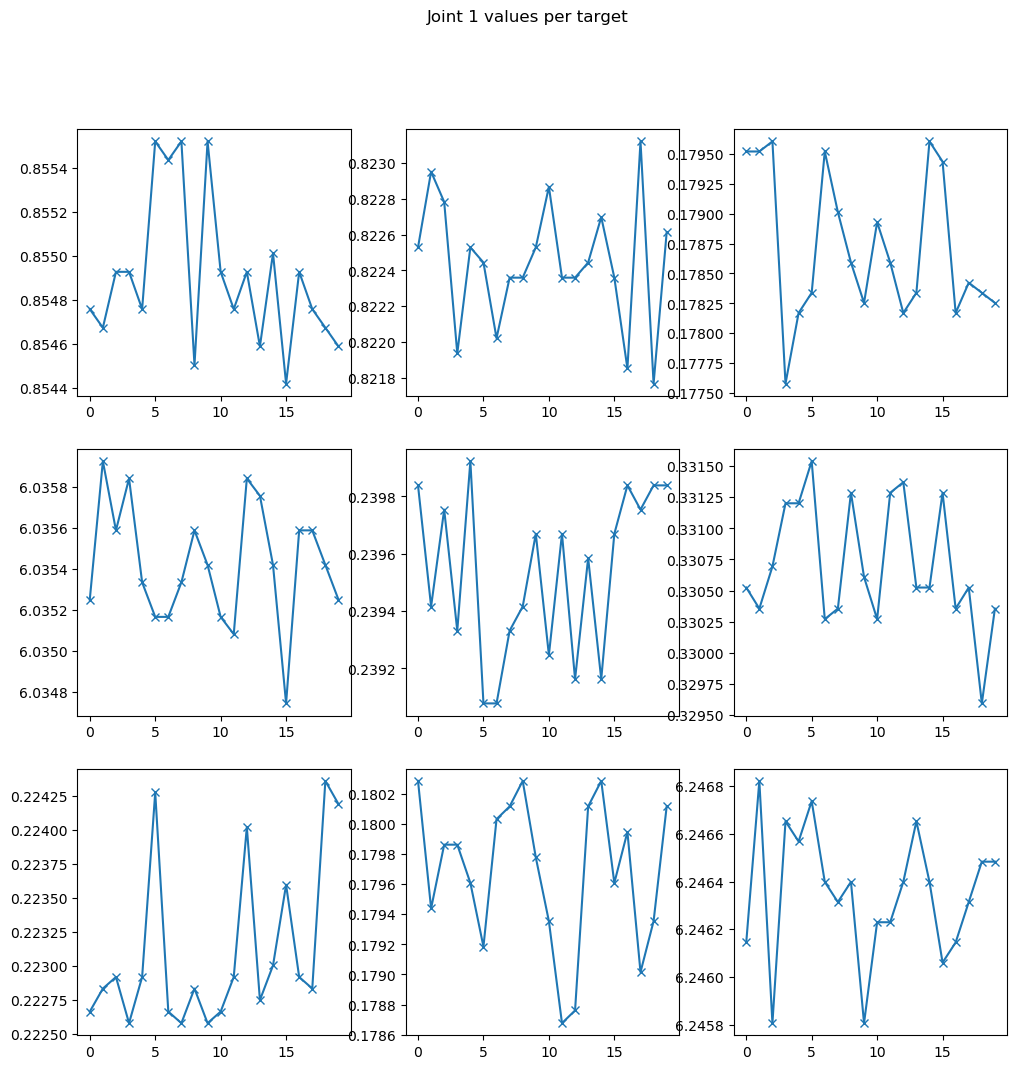

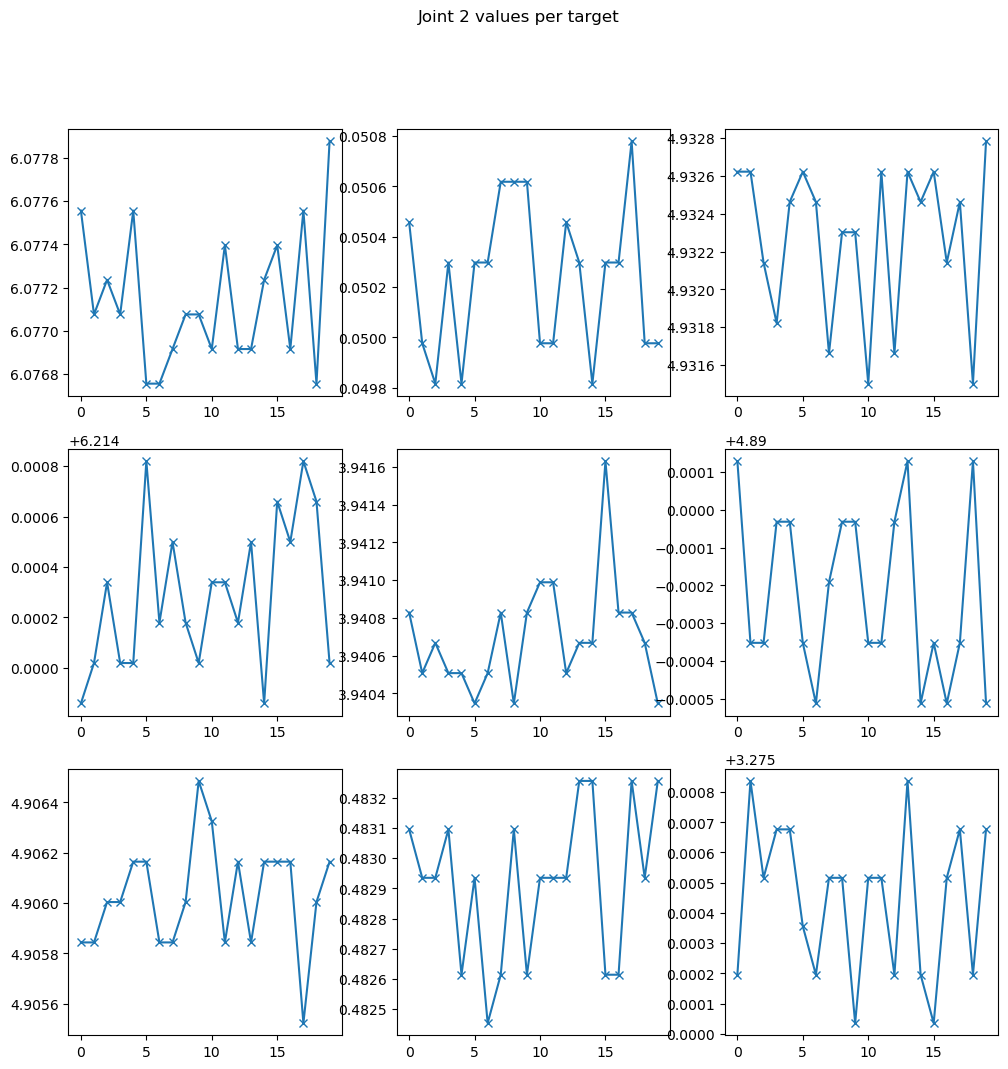

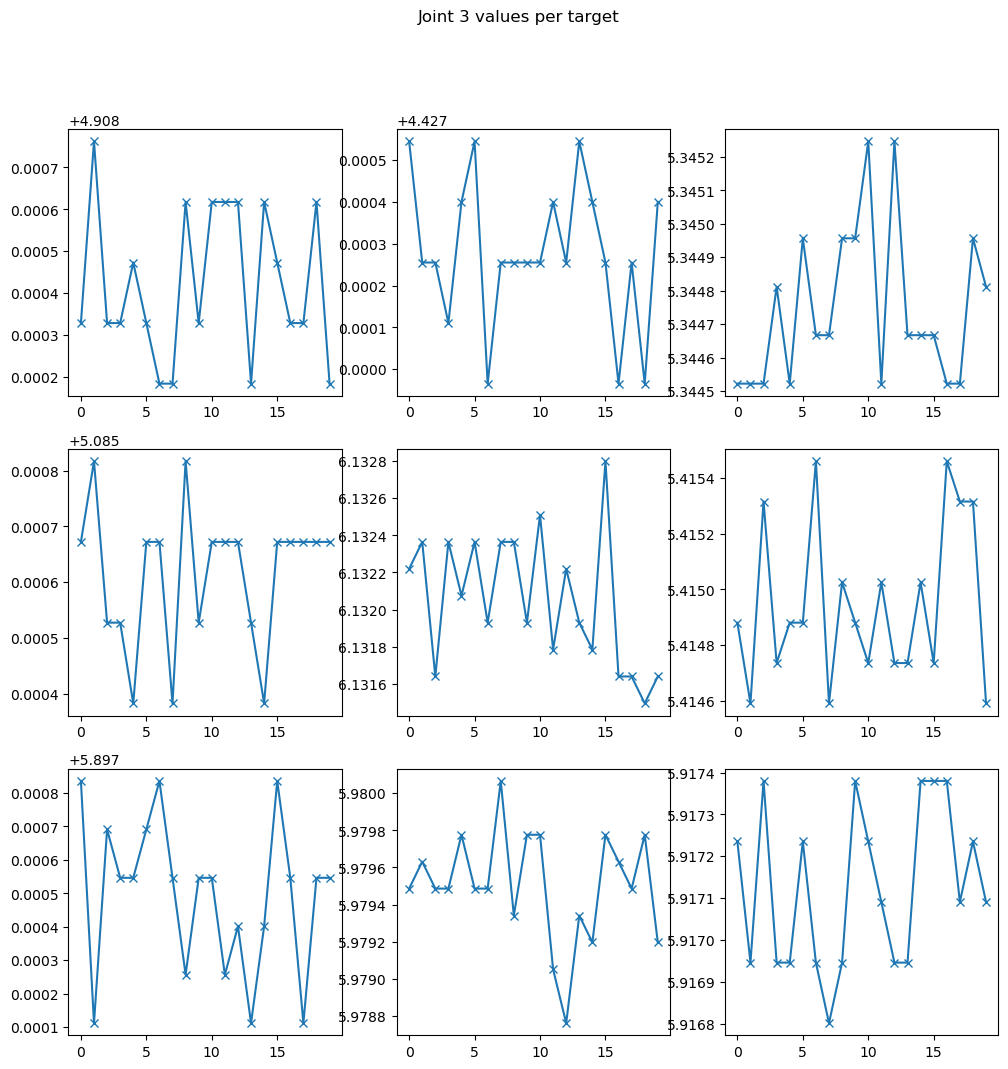

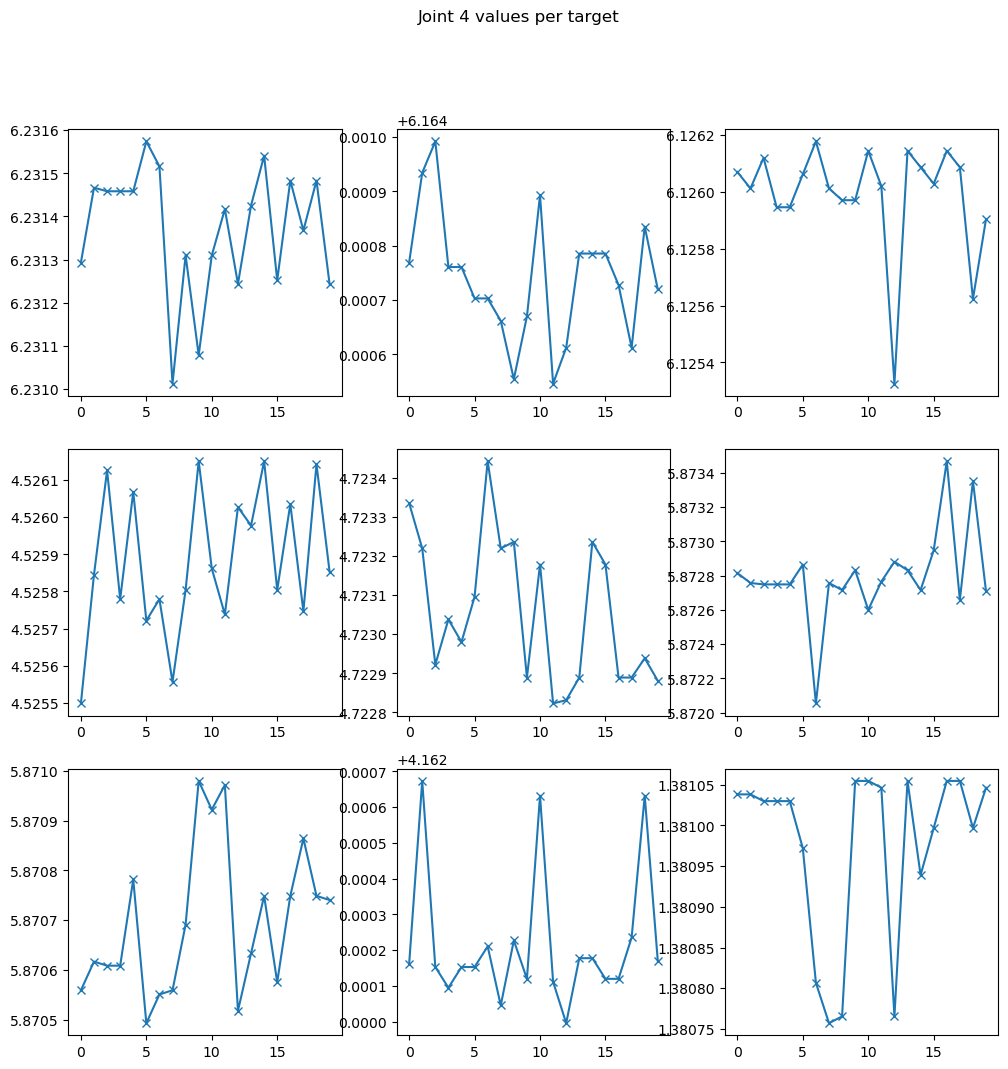

In [226]:
figs= []
for i in range(5):
    figs.append(plt.figure(figsize= (12,12), dpi= 100))
    figs[-1].suptitle('Joint ' + str(i) + ' values per target')

Xd = np.array([0.0]*5)

i = 0
for name in state_names:
    i+= 1
    ri = [rec for rec in recordings if rec[0] == name]
    X = np.array([r[2] for r in ri])
    X[:,:]= X[:,:]-(X[:,:]//np.tau)*np.tau
    Xd= np.vstack((Xd, X.max(axis= 0)-X.min(axis=0)))
    for j in range(5):
        figs[j].add_subplot(3,3,i).plot(X[:,j], '-x')

In [206]:
arm.get_active_joints()

['r_shoulder_pan_joint',
 'r_shoulder_lift_joint',
 'r_upper_arm_roll_joint',
 'r_elbow_flex_joint',
 'r_forearm_roll_joint']

AttributeError: module 'matplotlib.pyplot' has no attribute 'logbar'

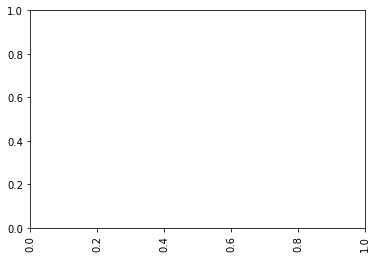

In [229]:
plt.xticks(rotation=90)
plt.logbar(arm.get_active_joints(), np.max(Xd))
plt.savefig('controller_goal_measurements_maximum_joint_error_over_targets.png', dpi=500)